# Task 5: Attention-Enhanced Conditional GAN Training
This notebook trains the self-attention CGAN (extension of Task 4) and collects metrics (loss curves, conditional accuracy, precision, recall, F1, confusion matrix).

## 1. Environment Setup

In [9]:
%pip install -q torch torchvision scikit-learn matplotlib seaborn transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Imports & Config

In [10]:
import os, torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import sys
sys.path.append('../task4')  # Adjust the path as needed to point to the location of task4
from gans import AttnGenerator, Discriminator, LATENT_DIM, N_CLASSES, conditional_accuracy, _build_or_load_mnist_classifier, weights_init_normal
from torchvision import datasets, transforms, utils
from torch import nn
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OUT='task5_outputs'; Path(OUT).mkdir(exist_ok=True)

## 3. Data Loader

In [11]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)

## 4. Initialize Models & Optimizers

In [12]:
G = AttnGenerator().to(DEVICE); D = Discriminator().to(DEVICE)
G.apply(weights_init_normal); D.apply(weights_init_normal)
criterion = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5,0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5,0.999))
history={'g':[], 'd':[]}

## 5. Training Loop (Attention CGAN)

In [13]:
EPOCHS=10
sample_every=2
for epoch in range(1,EPOCHS+1):
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        b = imgs.size(0)
        valid = torch.ones(b,1,device=DEVICE); fake = torch.zeros(b,1,device=DEVICE)
        # Train D
        opt_D.zero_grad()
        z = torch.randn(b, LATENT_DIM, device=DEVICE)
        gen = G(z, labels)
        real_loss = criterion(D(imgs, labels), valid)
        fake_loss = criterion(D(gen.detach(), labels), fake)
        d_loss = (real_loss + fake_loss)/2; d_loss.backward(); opt_D.step()
        # Train G
        opt_G.zero_grad()
        g_loss = criterion(D(gen, labels), valid); g_loss.backward(); opt_G.step()
    history['g'].append(g_loss.item()); history['d'].append(d_loss.item())
    if epoch % sample_every==0:
        with torch.no_grad():
            z = torch.randn(25, LATENT_DIM, device=DEVICE)
            lab = torch.arange(25, device=DEVICE) % N_CLASSES
            imgs_s = G(z, lab)*0.5+0.5
            utils.save_image(imgs_s, f'{OUT}/epoch_{epoch}.png', nrow=5)
    print(f'Epoch {epoch}/{EPOCHS} | D {d_loss.item():.4f} G {g_loss.item():.4f}')
torch.save(G.state_dict(), f'{OUT}/attn_generator.pt')
torch.save(D.state_dict(), f'{OUT}/discriminatortask5.pt')

Epoch 1/10 | D 0.6093 G 1.2484
Epoch 2/10 | D 0.6241 G 0.9620
Epoch 2/10 | D 0.6241 G 0.9620
Epoch 3/10 | D 0.6273 G 0.7805
Epoch 3/10 | D 0.6273 G 0.7805
Epoch 4/10 | D 0.6345 G 0.8345
Epoch 4/10 | D 0.6345 G 0.8345
Epoch 5/10 | D 0.6727 G 0.7418
Epoch 5/10 | D 0.6727 G 0.7418
Epoch 6/10 | D 0.6893 G 0.7703
Epoch 6/10 | D 0.6893 G 0.7703
Epoch 7/10 | D 0.6746 G 0.7274
Epoch 7/10 | D 0.6746 G 0.7274
Epoch 8/10 | D 0.6857 G 0.7657
Epoch 8/10 | D 0.6857 G 0.7657
Epoch 9/10 | D 0.6730 G 0.7417
Epoch 9/10 | D 0.6730 G 0.7417
Epoch 10/10 | D 0.6640 G 0.7565
Epoch 10/10 | D 0.6640 G 0.7565


## 6. Loss Curves

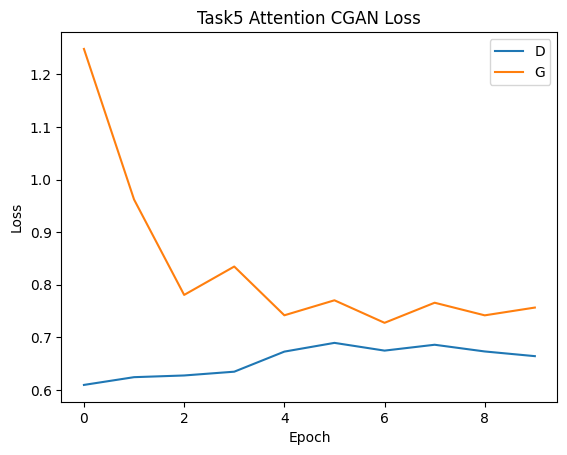

In [14]:
plt.plot(history['d'], label='D'); plt.plot(history['g'], label='G'); plt.legend(); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Task5 Attention CGAN Loss'); plt.savefig(f'{OUT}/loss_curves.png'); plt.show()

## 7. Conditional Accuracy & Metrics

In [15]:
clf = _build_or_load_mnist_classifier(DEVICE)
metrics = conditional_accuracy(G, clf, DEVICE)
metrics

{'accuracy': np.float64(0.779),
 'precision': 0.8650293037920667,
 'recall': 0.779,
 'f1': 0.7617952821362226}

## 8. Confusion Matrix Visualization

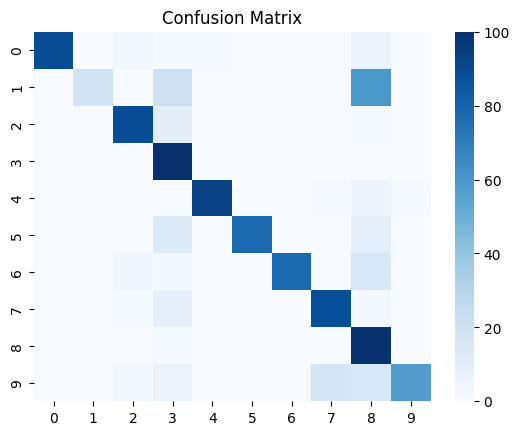

In [16]:
import numpy as np
labels = torch.arange(0,10, device=DEVICE).repeat_interleave(100)
with torch.no_grad():
    z = torch.randn(len(labels), LATENT_DIM, device=DEVICE)
    imgs = G(z, labels) * 0.5 + 0.5
preds = torch.argmax(clf((imgs-imgs.min())/(imgs.max()-imgs.min()+1e-8)), dim=1)
cm = confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())
sns.heatmap(cm, annot=False, cmap='Blues'); plt.title('Confusion Matrix'); plt.savefig(f'{OUT}/confusion_matrix.png'); plt.show()

## 9. Export Metrics

In [17]:
import json
with open(f'{OUT}/metrics.json','w') as f: json.dump(metrics, f, indent=2)
metrics

{'accuracy': np.float64(0.779),
 'precision': 0.8650293037920667,
 'recall': 0.779,
 'f1': 0.7617952821362226}

## 10. Summary
Training complete. Review images, loss curves, metrics, and confusion matrix in the output directory.